<a href="https://colab.research.google.com/github/MiguelOva/text_mining/blob/main/Bert_with_Tensorlfow%20-%20training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Text Mining Project

#### Spring 2022
#### Opinion Mining Evaluation Forum

#### Students m20200246 Pedro Costa & m2019XXXX Ana Bernardes

In [2]:
### Data import

In [3]:
# Loading file 
import pandas as pd
#df = pd.read_csv('training_set.txt', delimiter = '\t')
df_dev = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/dev_set.txt', delimiter = '\t')
df_train = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/training_set.txt', delimiter = '\t')
df_test = pd.read_csv('https://raw.githubusercontent.com/MiguelOva/text_mining/main/test_set.txt', delimiter = '\t')

In [4]:
import matplotlib as plt
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [5]:
len(df_train)

14000

In [6]:
df_train.head()

,sentence,emotion
0,I'm too old to be traded in .,6
1,Mother said you could always tell a lady by he...,8
2,I always said I'd leave off when the time came .,6
3,He'll be safe with me .,2
4,Lay off .,1


In [7]:
df_train = pd.DataFrame(data=df_train, columns=['sentence', 'emotion'])

In [8]:
df_train[100:400]

,sentence,emotion
100,What is the matter with you ?,1
101,"Ah , yes ! ' I had a migraine , your Majesty .",8
102,He was ... fine .,3
103,The best died there .,6
104,"What the hell is going on out there , [PERSON] ?",4
...,...,...
395,This is maybe the most important case that we ...,8
396,You think [PERSON]'s gonna buy that ?,4
397,"It's OK , I was thinking the same thing .",8
398,This is the captain speaking .,4


In [9]:
# Check for empty cells

"""""
Avaliar a necessidade de filtrar sentences vazias
"""""

df_train.isnull().sum()

sentence    0
emotion     0
dtype: int64

In [10]:
# Check emotion frequency
df_train.emotion.value_counts()

1    2999
2    2129
8    2095
5    1470
4    1442
6    1384
3    1343
7    1138
Name: emotion, dtype: int64

In [11]:
from tqdm import tqdm_notebook as tqdm
def label_counter(df, field):
    """
    ???????????
    """
    return df[field].value_counts()

In [12]:
label_counter(df_train, "emotion")

1    2999
2    2129
8    2095
5    1470
4    1442
6    1384
3    1343
7    1138
Name: emotion, dtype: int64

In [13]:
# Word Count
def word_count(text):
    """
    Function that counts text words
    """
    df_words = " ".join(text).split()
    # Count all words 
    freq = pd.Series(df_words).value_counts()
    return freq

In [14]:
word_count(list(df_train['sentence']))[:25]

.           10600
,            5738
you          3502
I            3208
to           2862
the          2703
?            2696
a            2320
!            1608
[PERSON]     1386
of           1358
and          1266
me           1195
it           1193
that         1156
in           1083
You           950
is            902
for           847
be            761
this          757
I'm           738
have          727
your          690
my            678
dtype: int64

In [15]:
#### Preprocessing

In [16]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from bs4 import BeautifulSoup

nltk.download('wordnet')
nltk.download('stopwords')

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
stem = SnowballStemmer("english")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def clean(text_in, lemmatize, stemmer):
    """
    Preprocessing Function  will consist of   
    - make everything lowercased
    - removing all symbols that are not letters
    - remove stopwords
    - replace words with the corresponding lemma

    """
    updates = []
    for j in tqdm(range(len(text_in))):
        
        text = text_in[j]
        
        #make everything lowercased
        text = text.lower()      
          
        #removing all symbols that are not letters
        text = re.sub("[^a-zA-Z]", ' ', text)
            
        #remove stopwords
        text = ' '.join([word for word in text.split() if word not in stop])
        
        #replace words with the corresponding lemma
        text = BeautifulSoup(text).get_text()
        
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        if stemmer:
            text = " ".join(stem.stemmer(word) for word in text.split())
        
        updates.append(text)
        
    return updates

In [18]:
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"sentence": list_updated}))

In [19]:
updates = clean(df_train["sentence"], lemmatize = True, stemmer = False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/14000 [00:00<?, ?it/s]

In [20]:
update_df(df_train, updates)
df_train

,sentence,emotion
0,old traded,6
1,mother said could always tell lady hand,8
2,always said leave time came,6
3,safe,2
4,lay,1
...,...,...
13995,yes commissioner,8
13996,ring,7
13997,greatest enduring love,5
13998,came back war son,5


In [21]:
word_count(df_train['sentence'])[:20]

person      1501
get          571
know         564
like         535
want         402
got          387
go           375
come         345
think        338
good         337
right        316
see          309
location     306
one          294
let          279
gonna        275
going        265
well         262
time         252
look         246
dtype: int64

# -------------------------------------------------------------------
## Bert with Tensorflow

In [22]:
#!pip install transformers

In [23]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from transformers import BertTokenizer

In [24]:
df_train

,sentence,emotion
0,old traded,6
1,mother said could always tell lady hand,8
2,always said leave time came,6
3,safe,2
4,lay,1
...,...,...
13995,yes commissioner,8
13996,ring,7
13997,greatest enduring love,5
13998,came back war son,5


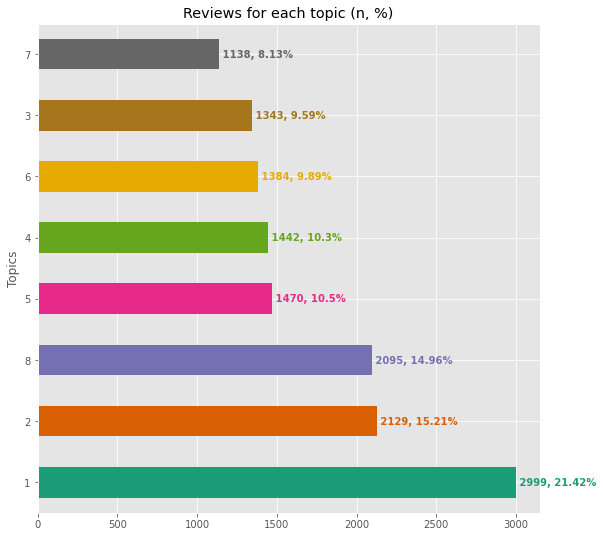

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


num_classes = len(df_train["emotion"].value_counts())

colors = plt.cm.Dark2(np.linspace(0, 1, num_classes))
iter_color = iter(colors)

df_train['emotion'].value_counts().plot.barh(title="Reviews for each topic (n, %)", 
                                                 ylabel="Topics",
                                                 color=colors,
                                                 figsize=(9,9))

for i, v in enumerate(df_train['emotion'].value_counts()):
  c = next(iter_color)
  plt.text(v, i,
           " "+str(v)+", "+str(round(v*100/df_train.shape[0],2))+"%", 
           color=c, 
           va='center', 
           fontweight='bold')

In [26]:
# map topic descriptions to labels
df_train['Labels'] = df_train['emotion'].map({1: 0,
                                            2: 1,
                                            3: 2,
                                            4: 3,
                                            5: 4,
                                            6: 5,
                                            7: 6,
                                            8: 7})

# drop unused column
df_train = df_train.drop(["emotion"], axis=1)

df_train.head()

,sentence,Labels
0,old traded,5
1,mother said could always tell lady hand,7
2,always said leave time came,5
3,safe,1
4,lay,0


In [27]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

y = tf.keras.utils.to_categorical(df_train["Labels"].values, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(df_train['sentence'], y, test_size=0.25)

In [28]:
#for Colab users: 
#!pip install tensorflow_text
#!pip install -U tensorflow-text==2.5


#for Colab users: 
#!pip install tensorflow_hub

In [29]:
import tensorflow_hub as hub
import tensorflow_text as text

preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")


def get_embeddings(sentences):
  '''return BERT-like embeddings of input text
  Args:
    - sentences: list of strings
  Output:
    - BERT-like embeddings: tf.Tensor of shape=(len(sentences), 768)
  '''
  preprocessed_text = preprocessor(sentences)
  return encoder(preprocessed_text)['pooled_output']


get_embeddings([
    "happens gold safe"]
)

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[ 1.46681860e-01, -3.36151779e-01,  3.57096195e-01,
        -7.25558877e-01, -3.04658026e-01, -1.71349887e-02,
        -1.85808599e-01, -8.36467624e-01,  6.08394668e-02,
        -8.97232831e-01, -2.52782732e-01, -3.09667379e-01,
         3.86174908e-03,  1.08122770e-02, -5.35260081e-01,
        -4.45027530e-01, -2.12689072e-01, -9.03081968e-02,
         4.73602712e-01, -4.58505243e-01, -4.45035130e-01,
         1.36959389e-01,  4.71701398e-02,  2.39395425e-01,
        -4.06448424e-01,  9.20297131e-02, -4.73015487e-01,
        -4.16619390e-01, -9.08360705e-02, -7.80843914e-01,
         2.74880230e-01, -3.85270149e-01, -6.97202325e-01,
        -4.74027246e-01, -3.65972579e-01,  3.59871119e-01,
        -1.24268964e-01,  2.52412021e-01, -1.83335453e-01,
        -8.12139884e-02, -5.09255290e-01, -1.52975336e-01,
        -7.24549353e-01,  7.58052230e-01,  1.48247316e-01,
         5.29089272e-02, -1.53988317e-01, -4.67252076e-01,
      

In [30]:
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)

model = tf.keras.Model(i, x)

In [31]:
n_epochs = 20

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name="accuracy")
]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", 
                                                      patience = 3,
                                                      restore_best_weights = True)

model.compile(optimizer = "adam",
              loss = "categorical_crossentropy",
              metrics = METRICS)

model_fit = model.fit(x_train, 
                      y_train, 
                      epochs = n_epochs,
                      validation_data = (x_test, y_test),
                      callbacks = [earlystop_callback])

Epoch 1/20
329/329 [==============================] - 158s 439ms/step - loss: 1.9538 - accuracy: 0.2514 - val_loss: 1.8212 - val_accuracy: 0.3200
Epoch 2/20
329/329 [==============================] - 143s 435ms/step - loss: 1.7987 - accuracy: 0.3293 - val_loss: 1.7911 - val_accuracy: 0.3294
Epoch 3/20
329/329 [==============================] - 143s 434ms/step - loss: 1.7512 - accuracy: 0.3495 - val_loss: 1.7657 - val_accuracy: 0.3449
Epoch 4/20
329/329 [==============================] - 143s 434ms/step - loss: 1.7244 - accuracy: 0.3654 - val_loss: 1.7688 - val_accuracy: 0.3480
Epoch 5/20
329/329 [==============================] - 143s 434ms/step - loss: 1.7021 - accuracy: 0.3704 - val_loss: 1.7552 - val_accuracy: 0.3554
Epoch 6/20
329/329 [==============================] - 143s 434ms/step - loss: 1.6958 - accuracy: 0.3788 - val_loss: 1.7548 - val_accuracy: 0.3569
Epoch 7/20
329/329 [==============================] - 143s 436ms/step - loss: 1.6862 - accuracy: 0.3816 - val_loss: 1.7701 -

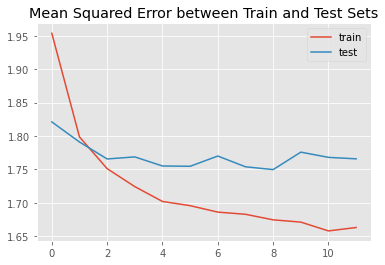

In [32]:
# plot history
import matplotlib.pyplot as pyplot 
pyplot.plot(model_fit.history['loss'], label='train')
pyplot.plot(model_fit.history['val_loss'], label='test')
pyplot.legend()
pyplot.title('Mean Squared Error between Train and Test Sets')
pyplot.show()

In [33]:
def predict_class(reviews):
  '''predict class of input text
  Args:
    - reviews (list of strings)
  Output:
    - class (list of int)
  '''
  return [np.argmax(pred) for pred in model.predict(reviews)]


In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

y_pred = predict_class(df_train["sentence"])

Accuracy: 39.71%

F1 Score: 39.71


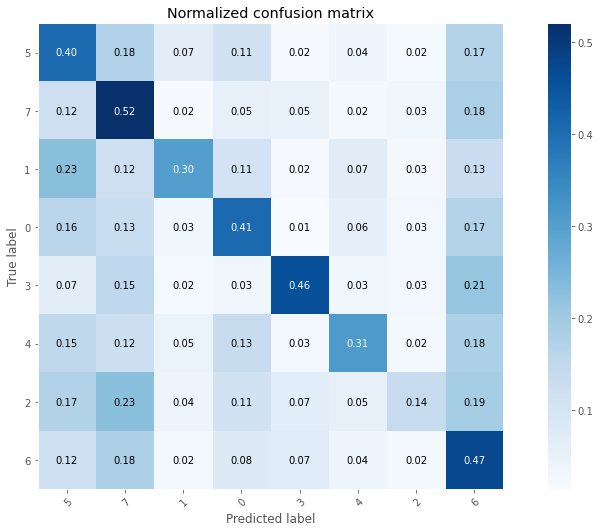

In [35]:
class_names = df_train['Labels'].unique().tolist()

print("Accuracy: {:.2f}%".format(accuracy_score(df_train['Labels'], y_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_train['Labels'], y_pred, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(df_train['Labels'], y_pred, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [36]:
from sklearn.metrics import classification_report

print(classification_report(df_train["Labels"], y_pred))

              precision    recall  f1-score   support

           0       0.44      0.40      0.42      2999
           1       0.37      0.52      0.43      2129
           2       0.46      0.30      0.37      1343
           3       0.35      0.41      0.37      1442
           4       0.59      0.46      0.52      1470
           5       0.45      0.31      0.37      1384
           6       0.32      0.14      0.19      1138
           7       0.32      0.47      0.38      2095

    accuracy                           0.40     14000
   macro avg       0.41      0.38      0.38     14000
weighted avg       0.41      0.40      0.39     14000

